In [36]:
from torchvision import transforms
from torchvision.datasets import ImageFolder

## 1 Data Preprocessing
### 1.1 Data Import

In [37]:
# choos directory of pictures
data_dir = "./images_original"


# Load full the dataset with original image size
# Define transformer: 
transform=transforms.Compose([transforms.Resize((288, 432)), transforms.ToTensor()])

# load data
dataset = ImageFolder(data_dir,  transform=transform)

# check output
print(dataset)


Dataset ImageFolder
    Number of datapoints: 999
    Root location: ./images_original
    StandardTransform
Transform: Compose(
               Resize(size=(288, 432), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )


### 1.2 Small Subset

In [39]:
# from torch.utils.data import Subset
# 
# 
# # Load a subset of the dataset*
# # criterion for subset, and  initialization
# class_counts = collections.defaultdict(int)
# max_per_class = 100  # maximum number of spectrograms per genre
# genre_indices = []
# 
# # Iterate through the dataset and select indices of spectrogram's*
# for idx, (img, label) in enumerate(dataset):
#     if class_counts[label] < max_per_class:
#         genre_indices.append(idx)
#         class_counts[label] += 1
#     # stopping criteria if all genres contain 10 spectrogram's
#     if len(class_counts) == len(dataset.classes) and all(c >= max_per_class for c in class_counts.values()):
#         break
#         
# # created subset with the selected indices*
# subset_data = Subset(dataset, genre_indices)
# 
# 
# # Check Subset
# print(f"Spectrogram's in subset: {len(subset_data)}")


Spectrogram's in subset: 999


### 1.3 Train-Test Split for Subset

In [35]:
# from sklearn.model_selection import train_test_split
# 
# # Train Ration
# train_ratio = 0.8
# 
# # Collect indices and labels
# all_indices = list(range(len(subset_data)))
# all_labels = [subset_data[i][1] for i in all_indices]  # Integer-Labels
# 
# # Stratified Split
# train_indices, test_indices = train_test_split(
#     all_indices,
#     train_size=train_ratio,
#     stratify=all_labels,
#     random_state=42  # for reproducibility
# )
# 
# # create subsets
# train_subset = Subset(subset_data, train_indices)
# test_subset = Subset(subset_data, test_indices)
# 
# # Create data loaders (load the train and validation into batches)
# train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
# test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)
# 
# # Print the number of samples in each set
# print(f"Number of training samples: {len(train_subset)}") 
# print(f"Number of testing samples: {len(test_subset)}")

### 1.3.2 Train-Validation-Test Split for whole Data



In [128]:
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from torch.utils.data import Subset, DataLoader

#  Extracting Tags
targets = [dataset[i][1] for i in range(len(dataset))]  # assuming (x, label)

# Stratified Split: 90% Train+Val, 10% Test
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
for train_val_idx, test_idx in sss.split(X=targets, y=targets):
    pass

# # Debug: Testverteilung
# test_targets = [targets[i] for i in test_idx]
# print("Test:", Counter(test_targets))

# Stratified K-Fold on Train+Val (90%)
train_val_targets = [targets[i] for i in train_val_idx]
skf = StratifiedKFold(n_splits=5)
batch_size = 32

for fold, (train_idx, val_idx) in enumerate(skf.split(train_val_idx, train_val_targets)):
    # Map indices back to original dataset
    train_indices = [train_val_idx[i] for i in train_idx]
    val_indices = [train_val_idx[i] for i in val_idx]

    train_targets = [targets[i] for i in train_indices]
    val_targets = [targets[i] for i in val_indices]

    # print(f"\nFold {fold+1}")
    # print("Train:", Counter(train_targets))
    # print("Validation:", Counter(val_targets))

    # Erstelle Subsets und Loader
    train_subset = Subset(dataset, train_indices)
    val_subset = Subset(dataset, val_indices)
    test_subset = Subset(dataset, test_idx)

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)


print(f"Number of training samples: {len(train_subset)}") 
print(f"Number of validation samples: {len(val_subset)}")
print(f"Number of test samples: {len(test_subset)}")

Number of training samples: 720
Number of validation samples: 179
Number of test samples: 100


Check how many samples are in each class and subset: 

In [44]:
from collections import Counter

# helper function to get distribution of classes
def get_dist(ds):
    return Counter([ds[i][1] for i in range(len(ds))])

# print distributions
print("Train:", get_dist(train_subset))
print("Validation:", get_dist(val_subset))
print("Test:", get_dist(test_subset))

Train: Counter({6: 72, 8: 72, 0: 72, 3: 72, 4: 72, 5: 72, 7: 72, 1: 72, 2: 72, 9: 72})
Validation: Counter({6: 18, 8: 18, 2: 18, 3: 18, 0: 18, 7: 18, 4: 18, 1: 18, 9: 18, 5: 17})
Test: Counter({3: 10, 4: 10, 1: 10, 0: 10, 9: 10, 7: 10, 2: 10, 8: 10, 5: 10, 6: 10})


## 2. Model
### 2.1.1 Base Model setup for testing

In [120]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Define a simple CNN
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 18 * 27, 1024)  # adjusted to your input size (288x432 / 4)
        self.fc2 = nn.Linear(1024, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # (3x288x432) -> (16x144x216)
        x = self.pool(F.relu(self.conv2(x)))  # (16x144x216) -> (32x72x108)
        x = self.pool2(F.relu(self.conv3(x)))  # (32x72x108) -> (64x36x54)
        x = self.pool2(F.relu(self.conv4(x)))  # (64x36x54) -> (64x18x27)
        x = x.view(x.size(0), -1)  # flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate model
num_classes = len(dataset.classes)
model = SimpleCNN(num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)

# Count Layers
num_Conv_layers = str(model).count("Conv")
num_linear_layers = str(model).count("Linear")

4
3


### 2.2 Training loop

In [105]:
import time
import pandas as pd

training_logs = []

# Training loop
num_epochs = 50

for epoch in range(num_epochs):
    start_time = time.time()

    # --- Training ---
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss
    train_acc = correct / total

    # --- Evaluation ---
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = correct / total
    end_time = time.time()
    epoch_time = end_time - start_time

    # --- Logging ---
    training_logs.append({
        "epoch": epoch + 1,
        "train_loss": train_loss,
        "train_accuracy": train_acc,
        "val_loss": val_loss,
        "val_accuracy": val_acc,
        "epoch_time_sec": epoch_time
    })

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.4f} | "
          f"Time: {epoch_time:.2f}s")

# Optional: Convert to DataFrame and save
logs_df = pd.DataFrame(training_logs)
logs_df.to_csv("training_logs.csv", index=False)


Epoch [1/50] Train Loss: 52.6200, Train Acc: 0.1278 | Validation Loss: 13.1964, Validation Acc: 0.1732 | Time: 49.92s
Epoch [2/50] Train Loss: 48.8348, Train Acc: 0.2194 | Validation Loss: 12.3946, Validation Acc: 0.2291 | Time: 49.66s
Epoch [3/50] Train Loss: 46.8318, Train Acc: 0.2167 | Validation Loss: 12.1088, Validation Acc: 0.2346 | Time: 46.63s
Epoch [4/50] Train Loss: 45.1971, Train Acc: 0.2681 | Validation Loss: 11.3593, Validation Acc: 0.3240 | Time: 46.54s
Epoch [5/50] Train Loss: 43.7177, Train Acc: 0.3042 | Validation Loss: 11.1748, Validation Acc: 0.3073 | Time: 47.11s
Epoch [6/50] Train Loss: 40.7927, Train Acc: 0.3431 | Validation Loss: 10.9410, Validation Acc: 0.2905 | Time: 45.77s
Epoch [7/50] Train Loss: 39.8753, Train Acc: 0.3556 | Validation Loss: 9.7584, Validation Acc: 0.4078 | Time: 47.45s
Epoch [8/50] Train Loss: 36.6722, Train Acc: 0.4306 | Validation Loss: 9.8122, Validation Acc: 0.3911 | Time: 47.91s
Epoch [9/50] Train Loss: 35.2575, Train Acc: 0.4472 | Vali

## 3. Evaluation
### 3.1 Evaluation with Test set

In [106]:
# Evaluation
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {correct / total:.4f}")


Test Accuracy: 0.5900


### 3.2 Ploting Training Results

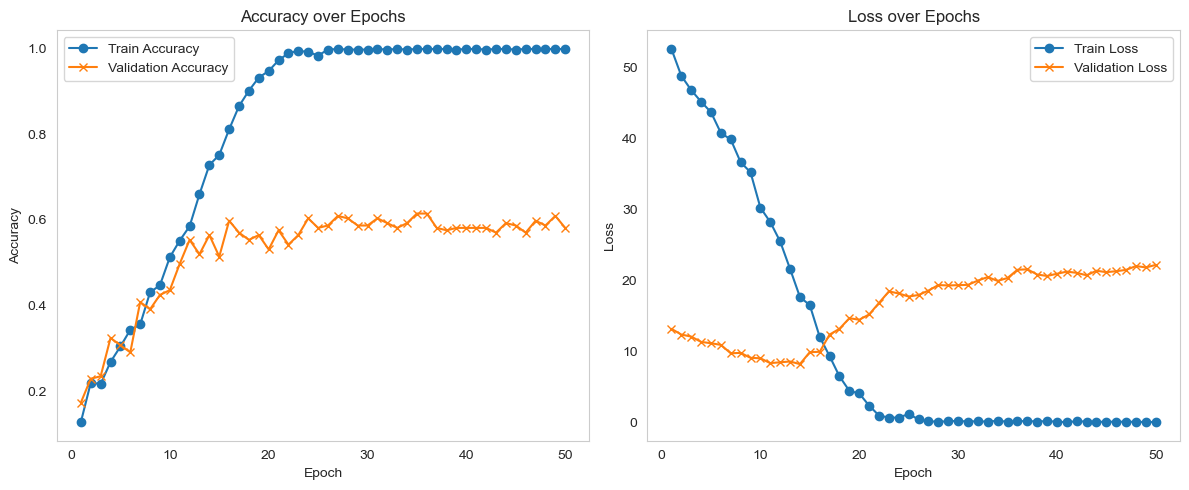

In [136]:
import matplotlib.pyplot as plt
from datetime import date


# Ensure your DataFrame logs_df exists
# logs_df = pd.read_csv("training_logs.csv")  # Optional: reload if needed

save_plot_files = True
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --- Accuracy subplot ---
axes[0].plot(logs_df["epoch"], logs_df["train_accuracy"], label="Train Accuracy", marker='o')
axes[0].plot(logs_df["epoch"], logs_df["val_accuracy"], label="Validation Accuracy", marker='x')
axes[0].set_title("Accuracy over Epochs")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].legend()
axes[0].grid(False)

# --- Loss subplot ---
axes[1].plot(logs_df["epoch"], logs_df["train_loss"], label="Train Loss", marker='o')
axes[1].plot(logs_df["epoch"], logs_df["val_loss"], label="Validation Loss", marker='x')
axes[1].set_title("Loss over Epochs")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].legend()
axes[1].grid(False)

plt.tight_layout()
if save_plot_files: 
    filename_acc_loss = f"{date.today().strftime('%y%m%d')}_Acc-Loss_conv{num_Conv_layers}_lin{num_linear_layers}_ep{num_epochs}_lr{lr}.png"
    plt.savefig(filename_acc_loss, dpi=600)
plt.show()


### 3.3 Classification Report and Confusion matrix


/opt/miniconda3/envs/NNandDL/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/NNandDL/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/NNandDL/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

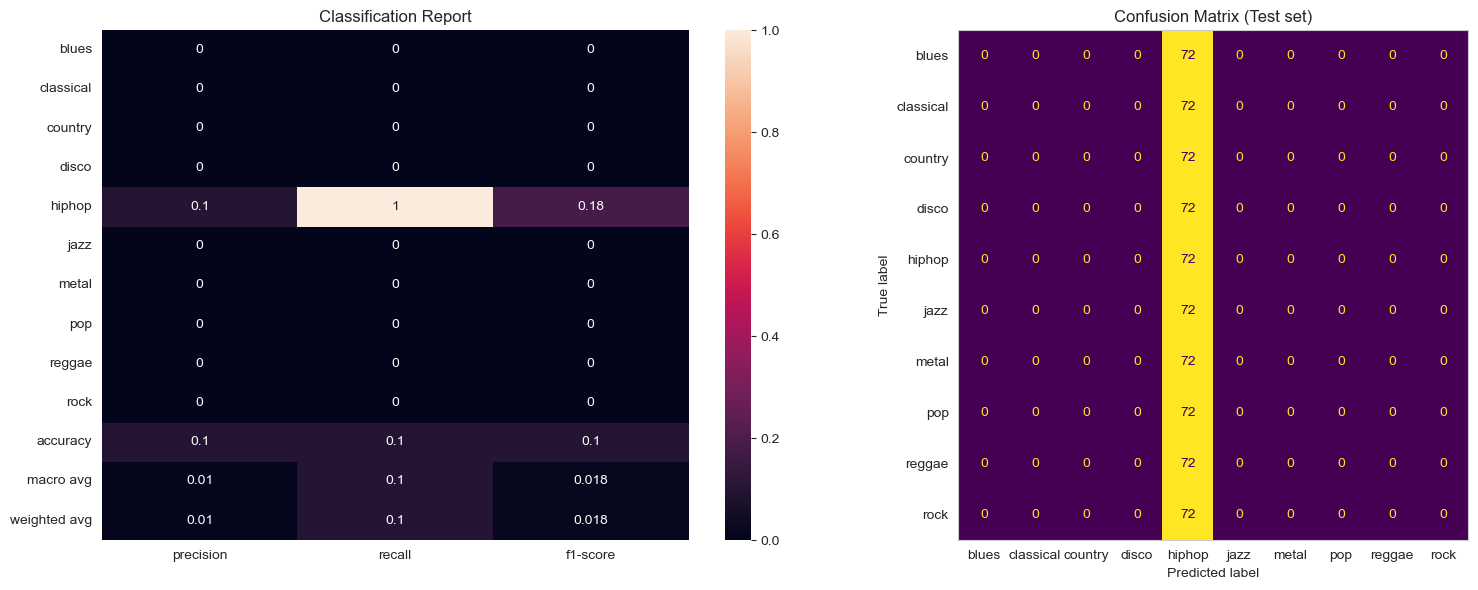

In [127]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd

# Save predictions
y_true = []
y_pred = []

save_plot_files = True

def save_predictions(model, test_loader):
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    return y_true, y_pred

save_predictions(model, test_loader)

# Extract labels and classification report
label_idx = [dataset.class_to_idx[i] for i in dataset.classes]
clf_report = classification_report(y_true, y_pred, labels=label_idx, target_names=dataset.classes, output_dict=True)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=label_idx)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Classification Report Heatmap
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, ax=ax1)
ax1.set_title('Classification Report')

# Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
disp.plot(ax=ax2, colorbar=False)  # Avoid duplicate colorbars
ax2.set_title('Confusion Matrix (Test set)')
ax2.grid(False)

plt.tight_layout()
if save_plot_files: 
    filename_clf_cm = f"{date.today().strftime('%y%m%d')}_clf-cm_conv{num_Conv_layers}_lin{num_linear_layers}_ep{num_epochs}_lr{lr}.png"
    plt.savefig(filename_clf_cm, dpi=600)
plt.show()


### 3.4 Saving Model Parameters
 

In [138]:
def save_model_summary(model, filepath="model_summary.txt", epochs=None, lr=None, optimizer=None, batch_size=None, device=None, max_per_class = None, epoch_times = None):
    with open(filepath, "w") as f:
        f.write("--- Model Architecture ---\n")
        f.write(str(model))
        f.write("\n\n--- Hyperparameters ---\n")
        if epochs is not None:
            f.write(f"Epochs: {epochs}\n")
        if lr is not None:
            f.write(f"Learning Rate: {lr}\n")
        if optimizer is not None:
            f.write(f"Optimizer: {optimizer.__class__.__name__}\n")
        if batch_size is not None:
            f.write(f"Batch Size: {batch_size}\n")
        if device is not None:
            f.write(f"Device: {device}\n")
        if max_per_class is not None:
            f.write(f"Subset size: {max_per_class}\n")
            
        if epoch_times is not None:
            total_time = sum(epoch_times)
            f.write(f"\n--- Runtime ---\n")
            f.write(f"Total training time: {total_time:.2f} seconds\n")    
            f.write(f"Mean training time: {total_time/num_epochs:.2f} seconds/epoch\n")            
        
        f.write("\n--- Parameters ---\n")
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        f.write(f"Total parameters: {total_params}\n")
        f.write(f"Trainable parameters: {trainable_params}\n")
        
    
filename_model_summary =  f"{date.today().strftime('%y%m%d')}_Model-Summary_conv{num_Conv_layers}_lin{num_linear_layers}_ep{num_epochs}_lr{lr}.txt"

epoch_times = logs_df['epoch_time_sec']

save_model_summary(model,
                   filepath=filename_model_summary, 
                   epochs=num_epochs,
                   lr=lr,
                   optimizer=optimizer,
                   batch_size=batch_size,
                   device=device,
                   max_per_class = None, 
                   epoch_times = epoch_times)